읽은 시트 이름: ['resident', 'medical', 'housing', 'movingpop', 'net_movingpop']
병합된 DataFrame shape: (30989, 173)
상위 100%(실제25%) 데이터 사용, shape: (30989, 173)
확장 요약 통계 feature shape: (30989, 70)
확장 요약 통계 feature 컬럼 예시: ['resident_Mean', 'resident_AbsMean', 'resident_Max', 'resident_Min', 'resident_Peak2Peak', 'resident_AbsMax', 'resident_RMS', 'resident_Variance', 'resident_ClearanceFactor', 'resident_Kurtosis']
최종 feature DataFrame shape (before 다중공선성 제거): (30989, 77)
최종 feature 컬럼 예시: ['resident_Mean', 'resident_AbsMean', 'resident_Max', 'resident_Min', 'resident_Peak2Peak', 'resident_AbsMax', 'resident_RMS', 'resident_Variance', 'resident_ClearanceFactor', 'resident_Kurtosis']
다중공선성으로 제거할 feature: ['resident_AbsMean', 'resident_Peak2Peak', 'resident_AbsMax', 'resident_RMS', 'resident_CrestFactor', 'medical_Mean', 'medical_AbsMean', 'medical_Max', 'medical_Min', 'medical_Peak2Peak', 'medical_AbsMax', 'medical_RMS', 'medical_Variance', 'medical_ClearanceFactor', 'medical_Kurtosis', 'medical_

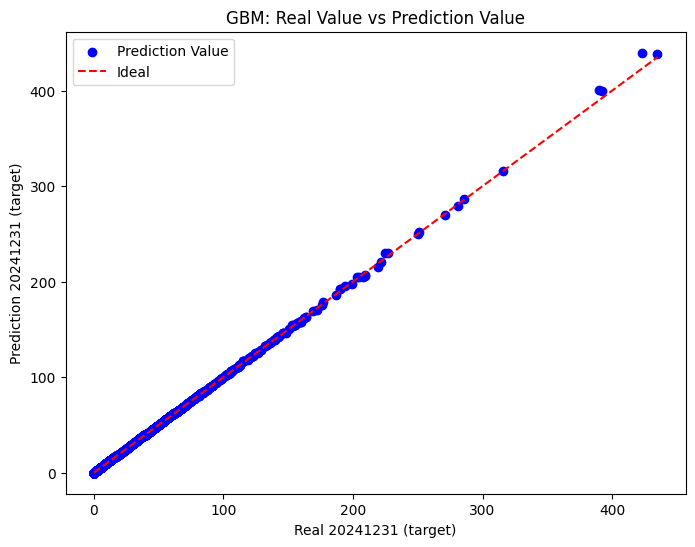

2025년 01월 예측 승객수 (GBM): [602.00289741 602.00289741 602.00289741 ... 201.08508848 298.94345286
 298.94345286]
2025년 02월 예측 승객수 (GBM): [602.00289741 602.00289741 602.00289741 ... 201.08508848 298.94345286
 298.94345286]


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import kurtosis, skew
import random

# ============================================
# 1. 엑셀 파일 읽기 및 시트 병합
# ============================================
# 실제 사용 시 아래 주석을 해제하여 파일을 읽으세요.
# excel_file = '(0203최종_2)상위25%_교집합_result.xlsx'
# sheets_dict = pd.read_excel(excel_file, sheet_name=None)
# 여기서는 sheets_dict가 이미 로드되었다고 가정합니다.

# 모든 시트의 열 이름 좌우 공백 제거
for sheet in sheets_dict:
    sheets_dict[sheet].columns = sheets_dict[sheet].columns.str.strip()

sheet_names = list(sheets_dict.keys())
print("읽은 시트 이름:", sheet_names)
# 예: ['resident', 'medical', 'housing', 'movingpop', 'net_movingpop']

# resident 시트의 22개월 승객수 열 이름 (원본 데이터)
months = ["20230331", "20230430", "20230531", "20230630", "20230731", "20230831",
          "20230930", "20231031", "20231130", "20231231", "20240131", "20240229",
          "20240331", "20240430", "20240531", "20240630", "20240731", "20240831",
          "20240930", "20241031", "20241130", "20241231"]

# 시간열의 위치: 앞 4열은 공통이므로, 인덱스 4부터 25까지 (22개 열)
time_series_start = 4
time_series_end = 26

# 첫 번째 시트 (resident) 처리:
first_sheet_df = sheets_dict[sheet_names[0]].copy()
cols = list(first_sheet_df.columns)
cols[time_series_start:time_series_end] = months  # resident 시트의 22개월 데이터 열 이름 재설정
first_sheet_df.columns = cols
common_cols = [col for col in first_sheet_df.columns if col not in months]

# ★★ resident 시트의 22개월 승객수 원본 데이터를 그대로 보존 (타깃 및 미래 예측에 사용)
raw_passenger_counts = first_sheet_df[months].copy()
raw_passenger_counts = raw_passenger_counts.apply(pd.to_numeric, errors='coerce').fillna(0)

# 병합: resident 시트는 그대로 사용하고, 나머지 시트는 22개월 데이터에 시트명을 접두어 붙여 병합
merged_df = first_sheet_df.copy()
for sheet in sheet_names[1:]:
    df = sheets_dict[sheet].copy()
    df_ts = df.iloc[:, time_series_start:time_series_end].copy()
    df_ts.columns = months
    df_ts.rename(columns=lambda x: f"{sheet}_{x}", inplace=True)
    merged_df = pd.concat([merged_df.reset_index(drop=True), df_ts.reset_index(drop=True)], axis=1)

merged_df.columns = merged_df.columns.str.strip()
print("병합된 DataFrame shape:", merged_df.shape)

# ============================================
# 2. 결측치 처리: 모든 numeric 열의 결측치를 해당 열 평균으로 채움
# ============================================
for col in merged_df.columns:
    try:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
    except Exception:
        continue
    if merged_df[col].dtype in [np.float64, np.int64]:
        col_mean = merged_df[col].mean()
        if pd.isna(col_mean):
            col_mean = 0
        merged_df[col] = merged_df[col].fillna(col_mean)

# ============================================
# 2.5 상위 25% 데이터 선택 (resident 시트의 22개월 승객수 원본 기준)
# ============================================
raw_passenger_counts = raw_passenger_counts.reset_index(drop=True)
raw_sum = raw_passenger_counts.sum(axis=1)
top_n = int(len(raw_sum) * 1.00)  # 상위 25% 선택
top_idx = raw_sum.sort_values(ascending=False).index[:top_n]
merged_df = merged_df.loc[top_idx].reset_index(drop=True)
raw_passenger_counts = raw_passenger_counts.loc[top_idx].reset_index(drop=True)
print("상위 100%(실제25%) 데이터 사용, shape:", merged_df.shape)

# ============================================
# 추가: 원본 행 번호 보존 (샘플 가중치 적용을 위해)
# ============================================
merged_df['row_index'] = merged_df.index

# ============================================
# 3. 확장 요약 통계 feature 계산 함수 (14개 지표)
# ============================================
def compute_summary_features(series):
    features = {}
    features["Mean"] = np.mean(series)
    features["AbsMean"] = np.mean(np.abs(series))
    features["Max"] = np.max(series)
    features["Min"] = np.min(series)
    features["Peak2Peak"] = np.ptp(series)
    features["AbsMax"] = np.max(np.abs(series))
    features["RMS"] = np.sqrt(np.mean(series**2))
    features["Variance"] = np.var(series)
    mean_cube = np.mean(np.abs(series)**3)
    if mean_cube == 0:
        features["ClearanceFactor"] = 0
    else:
        features["ClearanceFactor"] = (features["AbsMax"]**3 / mean_cube)**(1/3)
    features["Kurtosis"] = kurtosis(series)
    features["Skewness"] = skew(series)
    abs_mean = features["AbsMean"] if features["AbsMean"] != 0 else 1e-8
    features["ImpulseFactor"] = features["AbsMax"] / abs_mean
    rms = features["RMS"] if features["RMS"] != 0 else 1e-8
    features["CrestFactor"] = features["AbsMax"] / rms
    features["ShapeFactor"] = rms / abs_mean
    return features

# ============================================
# 추가: 행별 정규화 함수 (각 행을 마지막 값으로 나눔)
# ============================================
def normalize_row(row):
    last_val = row[-1] if row[-1] != 0 else 1
    return row / last_val

# ============================================
# 4. 시계열 요약 통계 feature 생성 (모든 5개 시트, 22개월 데이터)
#    → resident 시트의 feature에는 추가 가중치(multiplier)를 부여하여 강조
# ============================================
expanded_features = {}
resident_multiplier = 1000000000.0  # resident 시트 가중치 (필요에 따라 조정)
for sheet in sheet_names:
    if sheet == sheet_names[0]:
        cols = months
    else:
        cols = [f"{sheet}_{month}" for month in months]
    feat_list = [compute_summary_features(normalize_row(row)) for row in merged_df[cols].values]
    feat_df = pd.DataFrame(feat_list)
    if sheet == "resident":
        feat_df = feat_df * resident_multiplier
    feat_df = feat_df.add_prefix(f"{sheet}_")
    expanded_features[sheet] = feat_df

df_expanded = pd.concat(expanded_features.values(), axis=1)
print("확장 요약 통계 feature shape:", df_expanded.shape)
print("확장 요약 통계 feature 컬럼 예시:", df_expanded.columns.tolist()[:10])

# ============================================
# 5. 정적 feature 추출 및 가중치 적용
#    → 핵심 변수(E~Z, 즉 22개월 승객수 관련 feature)는 df_expanded,
#       정적 변수는 아래 6개와 resident 시트의 20241231 승객수를 'resident_last'로 추가
# ============================================
static_features = ["O_line_count", "O_exit_count", "O_busstop_count",
                   "D_line_count", "D_exit_count", "D_busstop_count"]
merged_df.columns = merged_df.columns.str.strip()
missing_static = [col for col in static_features if col not in merged_df.columns]
if missing_static:
    raise KeyError(f"다음 정적 feature가 데이터프레임에 없습니다: {missing_static}")
df_static = merged_df[static_features].copy().astype(float)
df_static["resident_last"] = raw_passenger_counts["20241231"]

# **중요:** 정적 feature의 스케일이 핵심 변수에 비해 매우 크므로 가중치를 낮춰준다.
static_weight = 0.01  # 정적 변수의 상대적 중요도를 낮추기 위한 가중치 (조정 가능)
df_static_weighted = df_static * static_weight

# 최종 feature DataFrame: 핵심 feature와 가중치 적용된 정적 feature 결합
X_features = pd.concat([df_expanded, df_static_weighted], axis=1)
print("최종 feature DataFrame shape (before 다중공선성 제거):", X_features.shape)
print("최종 feature 컬럼 예시:", X_features.columns.tolist()[:10])

# ============================================
# 6. 다중공선성 제거 (상관계수 절대값 0.95 이상인 feature 제거)
# ============================================
corr_matrix = X_features.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print("다중공선성으로 제거할 feature:", to_drop)
X_features_reduced = X_features.drop(columns=to_drop)
print("최종 feature DataFrame shape (after 다중공선성 제거):", X_features_reduced.shape)

# ============================================
# 7. 타깃 설정
#    → 기존 'weighted_average' 대신, resident 시트의 20241231 승객수 원본을 타깃으로 사용
# ============================================
y = raw_passenger_counts["20241231"].values.reshape(-1, 1).astype(float)
print("X_features_reduced 내 NaN 개수:", X_features_reduced.isna().sum().sum())
print("y 내 NaN 개수:", np.isnan(y).sum())

# ============================================
# 7.5 타깃 로그 변환 (승객수는 양수라 가정)
# ============================================
y_log = np.log1p(y)

# ============================================
# 8. 데이터 스케일링
#    → 입력 X는 RobustScaler 사용 (극단치 영향 최소화)
#    → 타깃 y는 로그변환 후 RobustScaler 적용, 나중에 expm1 복원
# ============================================
scaler_X = RobustScaler()
X_scaled = scaler_X.fit_transform(X_features_reduced.astype(float))

scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(y_log).ravel()

print("스케일된 X (상위 5행):\n", X_scaled[:5])
print("스케일된 y (상위 5행):", y_scaled[:5])

# 학습에 사용한 feature 컬럼 순서를 저장 (미래 예측 시 사용)
train_feature_columns = X_features_reduced.columns

# ============================================
# 9. 모델별 하이퍼파라미터 후보군 및 랜덤 서치
# ============================================
param_grids = {
    'RandomForest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    'XGBoost': {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.05, 0.1],
        "min_child_weight": [1, 3, 5],
        "subsample": [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.8, 1.0]
    },
    'GBM': {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.7, 0.8, 1.0]
    },
    'LightGBM': {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 5, 7, -1],
        "learning_rate": [0.01, 0.05, 0.1],
        "num_leaves": [31, 50, 70],
        "subsample": [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.8, 1.0]
    },
    'CatBoost': {
        "iterations": [100, 200, 300],
        "depth": [3, 5, 7],
        "learning_rate": [0.01, 0.05, 0.1],
        "l2_leaf_reg": [1, 3, 5],
        "rsm": [0.7, 0.8, 1.0]
    }
}

n_iter = 5
tscv = TimeSeriesSplit(n_splits=3)

def evaluate_model(model_type, params):
    cv_scores = []
    for train_idx, val_idx in tscv.split(X_scaled):
        X_cv_train, X_cv_val = X_scaled[train_idx], X_scaled[val_idx]
        y_cv_train, y_cv_val = y_scaled[train_idx], y_scaled[val_idx]
        if model_type == 'RandomForest':
            model = RandomForestRegressor(**params, random_state=42)
        elif model_type == 'XGBoost':
            model = XGBRegressor(**params, random_state=42, verbosity=0)
        elif model_type == 'GBM':
            model = GradientBoostingRegressor(**params, random_state=42)
        elif model_type == 'LightGBM':
            model = lgb.LGBMRegressor(**params, random_state=42)
        elif model_type == 'CatBoost':
            model = CatBoostRegressor(**params, random_state=42, verbose=0)
        else:
            raise ValueError("알 수 없는 모델 타입입니다.")
        model.fit(X_cv_train, y_cv_train)
        preds = model.predict(X_cv_val)
        cv_loss = mean_squared_error(y_cv_val, preds)
        cv_scores.append(cv_loss)
    return np.mean(cv_scores)

model_results = {}
for model_type, grid in param_grids.items():
    print(f"\n==== 모델 종류: {model_type} ====")
    best_score = np.inf
    best_params = None
    for i in range(n_iter):
        params = {k: random.choice(v) for k, v in grid.items()}
        print(f"\n[Iteration {i+1}] {model_type} 후보 하이퍼파라미터: {params}")
        score = evaluate_model(model_type, params)
        print(f"평균 CV MSE: {score:.20f}")
        if score < best_score:
            best_score = score
            best_params = params
    model_results[model_type] = {"best_params": best_params, "cv_mse": best_score}
    print(f"\n>> {model_type} 모델 최적 하이퍼파라미터: {best_params}")
    print(f">> {model_type} 모델 최소 평균 CV MSE: {best_score:.20f}")

print("\n===============================")
print("모델별 최적 CV MSE 성능지표:")
for m_type, res in model_results.items():
    print(f"{m_type} 모델: 최적 CV MSE = {res['cv_mse']:.20f}")

# ============================================
# 최종 모델 선정: 샘플 가중치를 적용하여 초반 데이터 반영
# ============================================
X_train_full, X_test, y_train_full, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y_scaled, merged_df['row_index'].values, test_size=0.2, random_state=42)

# 초기(원본 row_index 낮은) 샘플에 높은 가중치 부여 (예: 상위 20%에 1.5, 그 외 1.0)
n_total = len(merged_df)
sample_weights_train = np.where(idx_train < (0.2 * n_total), 1.5, 1.0)

sorted_models = sorted(model_results.items(), key=lambda x: x[1]["cv_mse"])
selected_model_type = None
selected_model_params = None
std_threshold = 1e-5

for model_type, res in sorted_models:
    params = res["best_params"]
    if model_type == 'RandomForest':
        model = RandomForestRegressor(**params, random_state=42)
    elif model_type == 'XGBoost':
        model = XGBRegressor(**params, random_state=42, verbosity=0)
    elif model_type == 'GBM':
        model = GradientBoostingRegressor(**params, random_state=42)
    elif model_type == 'LightGBM':
        model = lgb.LGBMRegressor(**params, random_state=42)
    elif model_type == 'CatBoost':
        model = CatBoostRegressor(**params, random_state=42, verbose=0)
    model.fit(X_scaled, y_scaled)
    preds_candidate = model.predict(X_scaled)
    if np.std(preds_candidate) > std_threshold:
        selected_model_type = model_type
        selected_model_params = params
        print(f"\n선택된 모델: {model_type} (CV MSE = {res['cv_mse']:.20f}, 예측 표준편차 = {np.std(preds_candidate):.20f})")
        break

if selected_model_type is None:
    selected_model_type, best_model_info = sorted_models[0]
    selected_model_params = best_model_info["best_params"]
    print(f"\n모든 후보가 상수 예측이므로, 가장 낮은 CV MSE 모델({selected_model_type})을 사용합니다.")

if selected_model_type == 'RandomForest':
    final_model = RandomForestRegressor(**selected_model_params, random_state=42)
elif selected_model_type == 'XGBoost':
    final_model = XGBRegressor(**selected_model_params, random_state=42, verbosity=0)
elif selected_model_type == 'GBM':
    final_model = GradientBoostingRegressor(**selected_model_params, random_state=42)
elif selected_model_type == 'LightGBM':
    final_model = lgb.LGBMRegressor(**selected_model_params, random_state=42)
elif selected_model_type == 'CatBoost':
    final_model = CatBoostRegressor(**selected_model_params, random_state=42, verbose=0)
else:
    raise ValueError("알 수 없는 모델 타입입니다.")

final_model.fit(X_train_full, y_train_full, sample_weight=sample_weights_train)
y_pred_scaled = final_model.predict(X_test)
y_pred_log = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_pred = np.expm1(y_pred_log)  # 로그 복원
y_test_inv_log = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_test_inv = np.expm1(y_test_inv_log)
test_mse = mean_squared_error(y_test_inv, y_pred)
print(f"\n최종 {selected_model_type} 모델 테스트 MSE:", test_mse)

plt.figure(figsize=(8,6))
plt.scatter(y_test_inv, y_pred, color='blue', label='Prediction Value')
plt.plot([y_test_inv.min(), y_test_inv.max()],
         [y_test_inv.min(), y_test_inv.max()],
         'r--', label='Ideal')
plt.xlabel("Real 20241231 (target)")
plt.ylabel("Prediction 20241231 (target)")
plt.title(f"{selected_model_type}: Real Value vs Prediction Value")
plt.legend()
plt.show()

# ============================================
# 10. 미래 예측: 2025년 01월 및 2025년 02월 승객수 예측
# ============================================
def forecast_summary(historical, n_future):
    """
    historical: (n_samples, 22) 배열, resident 시트의 원본 22개월 승객수 데이터
    n_future: 미래 이동 칸 수 (1: 2025년 01월, 2: 2025년 02월)
    슬라이딩 윈도우 방식: 처음 n_future 열 제거하고, 마지막 관측치(20241231 값)를 n_future 번 반복하여 붙임
    """
    last_value = historical[:, -1:]  # (n_samples, 1)
    new_data = np.concatenate([historical[:, n_future:], np.repeat(last_value, n_future, axis=1)], axis=1)
    return new_data

# --- 2025년 01월 예측 (n_future = 1) ---
forecast_features_202501 = [compute_summary_features(normalize_row(row))
                            for row in forecast_summary(raw_passenger_counts.values, 1)]
df_forecast_202501 = pd.DataFrame(forecast_features_202501).add_prefix("resident_")
# 정적 feature는 그대로 사용, resident_last는 raw_passenger_counts의 20241231 값
df_static_future = merged_df[static_features].copy().astype(float)
df_static_future["resident_last"] = raw_passenger_counts["20241231"]
X_future_202501 = pd.concat([df_forecast_202501, df_static_future], axis=1)
X_future_202501 = X_future_202501.reindex(columns=train_feature_columns, fill_value=0)
X_future_202501_scaled = scaler_X.transform(X_future_202501.astype(float))
y_future_202501_scaled = final_model.predict(X_future_202501_scaled)
y_future_202501_log = scaler_y.inverse_transform(y_future_202501_scaled.reshape(-1, 1))
y_future_202501 = np.expm1(y_future_202501_log)
print("2025년 01월 예측 승객수 ({}):".format(selected_model_type), y_future_202501.flatten())

# --- 2025년 02월 예측 (n_future = 2) ---
forecast_features_202502 = [compute_summary_features(normalize_row(row))
                            for row in forecast_summary(raw_passenger_counts.values, 2)]
df_forecast_202502 = pd.DataFrame(forecast_features_202502).add_prefix("resident_")
X_future_202502 = pd.concat([df_forecast_202502, df_static_future], axis=1)
X_future_202502 = X_future_202502.reindex(columns=train_feature_columns, fill_value=0)
X_future_202502_scaled = scaler_X.transform(X_future_202502.astype(float))
y_future_202502_scaled = final_model.predict(X_future_202502_scaled)
y_future_202502_log = scaler_y.inverse_transform(y_future_202502_scaled.reshape(-1, 1))
y_future_202502 = np.expm1(y_future_202502_log)
print("2025년 02월 예측 승객수 ({}):".format(selected_model_type), y_future_202502.flatten())


In [68]:
# ===== 머신러닝 모델 결과 출력용 추가 코드 =====
# 원본 시트(첫 번째 시트)에서 문자열 열 복원
# (실제 원본의 문자열 열 이름을 확인 후 사용; 여기서는 예시로 '승차_호선', '승차_역', '하차_호선', '하차_역' 사용)
original_df = sheets_dict[sheet_names[0]].copy()
for col in ["승차_호선", "승차_역", "하차_호선", "하차_역"]:
    if col in original_df.columns:
        merged_df[col] = original_df[col]
    else:
        print(f"주의: 원본 데이터에 '{col}' 열이 없습니다.")

# 예측 결과(y_future_202501, y_future_202502)는 이미 계산되었으므로,
# 이를 1차원 배열로 변환하여 새 열로 추가합니다.
merged_df["2025년 01월 예측승객수"] = y_future_202501.flatten()
merged_df["2025년 02월 예측승객수"] = y_future_202502.flatten()

# 결과 확인: 상위 5행 출력
merged_df

,승차_호선,승차_역,하차_호선,하차_역,20230331,20230430,20230531,20230630,20230731,20230831,...,net_movingpop_20240630,net_movingpop_20240731,net_movingpop_20240831,net_movingpop_20240930,net_movingpop_20241031,net_movingpop_20241130,net_movingpop_20241231,row_index,2025년 01월 예측승객수,2025년 02월 예측승객수
0,1호선,가산디지털단지,1호선,관악,795,0,784,759,692,814,...,102,747,151,838,821,166,606,0,602.002897,602.002897
1,1호선,가산디지털단지,1호선,군포,728,0,728,728,629,733,...,86,635,117,702,693,109,555,1,602.002897,602.002897
2,1호선,가산디지털단지,1호선,금정,683,0,681,686,619,678,...,52,611,72,644,631,82,487,2,602.002897,602.002897
3,1호선,가산디지털단지,1호선,당정,491,424,395,529,315,532,...,412,383,592,404,555,623,322,3,602.002897,602.002897
4,1호선,가산디지털단지,1호선,동암,545,0,574,543,511,568,...,66,660,72,746,752,110,539,4,602.002897,602.002897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30984,인천지하철 2호선,주안,공항철도,디지털미디어시티,1,0,2,3,3,1,...,4,2,3,8,6,5,2,30984,201.085088,201.085088
30985,인천지하철 2호선,주안국가산단,1호선,개봉,3,5,4,1,3,3,...,3,3,2,3,4,3,4,30985,402.122011,402.122011
30986,인천지하철 2호선,주안국가산단,2호선,신도림,5,1,2,4,4,3,...,1,5,0,3,2,2,2,30986,201.085088,201.085088
30987,인천지하철 2호선,주안국가산단,7호선,가산디지털단지,4,0,6,8,2,2,...,0,7,3,5,4,0,3,30987,298.943453,298.943453


In [56]:
merged_df.to_excel('/root/(0203최종)NumberPrediction_ML.xlsx')

In [78]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb

from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

################################################################################
# 1. 엑셀 다중 시트 로드 (시트별)
################################################################################
# 실제 사용시 아래 주석 해제 + 경로 지정
# excel_file = "path/to/your_file.xlsx"
# sheets_dict = pd.read_excel(excel_file, sheet_name=None)

# 여기서는 sheets_dict가 이미 로드되었다고 가정
# sheets_dict = {
#     "resident": resident_df,  # 예: 22개월 시계열 (E~Z)
#     "some_other_sheet": df2,  # 예: 부수적
#     ...
# }

for s in sheets_dict:
    sheets_dict[s].columns = sheets_dict[s].columns.str.strip()

sheet_names = list(sheets_dict.keys())
print("시트 목록:", sheet_names)

################################################################################
# 2. resident 시트에서 (E~Z) → 2023년03월 ~ 2024년12월 승객수
################################################################################
months = [
    "20230331","20230430","20230531","20230630","20230731","20230831",
    "20230930","20231031","20231130","20231231","20240131","20240229",
    "20240331","20240430","20240531","20240630","20240731","20240831",
    "20240930","20241031","20241130","20241231"
]
time_series_start = 4  # E열
time_series_end   = 26 # Z열(슬라이싱 시에는 end+1)

resident_df = sheets_dict[sheet_names[0]].copy()
cols = list(resident_df.columns)
cols[time_series_start:time_series_end] = months
resident_df.columns = cols

# 원본 승객수 (22개월)
raw_passenger_counts = resident_df[months].copy()
raw_passenger_counts = raw_passenger_counts.apply(pd.to_numeric, errors='coerce').fillna(0)

# 필요시: 상위 25%만 선별 (본 예시에선 전체 사용)
raw_passenger_counts = raw_passenger_counts.reset_index(drop=True)

################################################################################
# 3. "Lag feature"를 만들어 시계열 순서 반영
#    - 예: lag=12 로 설정 (12개월 치를 feature)
################################################################################
def make_lag_features(ts_array, max_lag=12):
    """
    ts_array: shape = (N, T)
      - N은 지역(또는 역) 개수
      - T는 시계열 길이(=22개월)
    max_lag: lag 개수 (예: 12)
    
    return: (X, y)
      - X.shape = (N*(T - max_lag), max_lag)
      - y.shape = (N*(T - max_lag), )
      예) T=22, max_lag=12라면, 각 행(지역)마다 (22-12)=10개의 훈련샘플 생성
          X에는 직전 12개월 데이터를 쌓고, y는 '현재 달' 데이터를 둠.
    """
    data_list = []
    target_list = []

    for i in range(ts_array.shape[0]):  # 각 지역(행)
        series = ts_array[i, :]  # 길이 T=22
        for t in range(max_lag, len(series)):
            x_feats = series[t-max_lag:t]  # 직전 12개월
            y_val   = series[t]            # 현재 달
            data_list.append(x_feats)
            target_list.append(y_val)
    
    X_lag = np.array(data_list)     # shape=(N*(T-max_lag), max_lag)
    y_lag = np.array(target_list)   # shape=(N*(T-max_lag),)
    return X_lag, y_lag

max_lag = 12  # 12개월을 feature로 사용
X_lag, y_lag = make_lag_features(raw_passenger_counts.values, max_lag)

print("X_lag.shape =", X_lag.shape)  # (N*(22-12), 12)
print("y_lag.shape =", y_lag.shape)  # (N*(22-12),)

################################################################################
# 4. 추가(부수적) Feature가 있다면 함께 합치기 (옵션)
#    - 예: 각 지역의 정적 변수 or 평균증가율
#    - 여기서는 예시로, 'merged_df'의 일부 열을 X_lag에 추가할 수 있음
################################################################################

# (예시) 만약 'merged_df'에서 부수적 feature (정적·평균증가율 등)를 가져온다면:
#   - 유의: 부수적 feature는 "지역 단위"이므로, 시간축 구별 없이 동일하게 붙게 됨
#   - X_lag는 'N*(T-max_lag)' 행이므로, 같은 지역이라도 (T-max_lag)개 row가 생김
#     → 이를 위해선, 각 row가 어느 지역 + 어느 시점인지 추적해야 함
#   - 아래는 간단 예시(생략):
#
# merged_df = resident_df.copy()  # 예시
# merged_df["avg_growth"] = ...   # 예시
# ...
# # row_index, etc.로 매핑 후 X_lag와 합치는 구조 구현 필요

################################################################################
# 5. 타깃 변환 (로그 등)
################################################################################
y_log = np.log1p(y_lag)

# 여기서는 X_lag 자체가 이미 “값의 크기”가 크지 않을 수 있음
# 필요하다면 X_lag도 스케일링 가능
scaler_X = RobustScaler()
X_lag_scaled = scaler_X.fit_transform(X_lag)

scaler_y = RobustScaler()
y_lag_scaled = scaler_y.fit_transform(y_log.reshape(-1,1)).ravel()

################################################################################
# 6. 모델 후보 + 하이퍼파라미터 셋업
################################################################################
param_grids = {
    'RandomForest': {
        "n_estimators": [100, 200, 300, 500],
        "max_depth": [3, 5, 10, 15, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    'XGBoost': {
        "n_estimators": [300, 500, 700],
        "max_depth": [3, 4, 5, 6],
        "learning_rate": [0.001, 0.01, 0.05],
        "min_child_weight": [1, 3, 5],
        "subsample": [0.6, 0.8, 1.0],
        "reg_alpha": [0, 0.1, 1],
        "reg_lambda": [1, 3, 5]
    },
    'GBM': {
        "n_estimators": [300, 500, 700],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.001, 0.01, 0.05],
        "subsample": [0.6, 0.8, 1.0]
        # sklearn의 GradientBoostingRegressor에는 alpha/lambda 직접 제공X
    },
    'LightGBM': {
        "n_estimators": [300, 500, 700],
        "max_depth": [3, 5, 7, -1],
        "learning_rate": [0.001, 0.01, 0.05],
        "num_leaves": [31, 50, 70],
        "subsample": [0.6, 0.8, 1.0],
        "reg_alpha": [0, 0.1, 1],
        "reg_lambda": [1, 3, 5]
    },
    'CatBoost': {
        "iterations": [300, 500, 700],
        "depth": [3, 5, 7],
        "learning_rate": [0.001, 0.01, 0.05],
        "l2_leaf_reg": [1, 3, 5],
        "rsm": [0.6, 0.8, 1.0]
    }
}

n_iter = 5  # 간단히 3회만 랜덤샘플링

################################################################################
# 7. 시계열 교차검증 (TimeSeriesSplit) 적용
################################################################################
tscv = TimeSeriesSplit(n_splits=3)

def get_model_by_type(mtype, params):
    if mtype == "RandomForest":
        return RandomForestRegressor(**params, random_state=42)
    elif mtype == "XGBoost":
        return XGBRegressor(**params, random_state=42, verbosity=0)
    elif mtype == "GBM":
        return GradientBoostingRegressor(**params, random_state=42)
    elif mtype == "LightGBM":
        return lgb.LGBMRegressor(**params, random_state=42)
    elif mtype == "CatBoost":
        return CatBoostRegressor(**params, random_state=42, verbose=0)
    else:
        raise ValueError("알 수 없는 모델 타입")

def evaluate_model(mtype, params):
    # 상수 예측 / 큰 예측 배제 등은 필요시 추가 가능
    cv_scores = []
    for tr_idx, val_idx in tscv.split(X_lag_scaled):
        X_tr, X_val = X_lag_scaled[tr_idx], X_lag_scaled[val_idx]
        y_tr, y_val = y_lag_scaled[tr_idx], y_lag_scaled[val_idx]

        model = get_model_by_type(mtype, params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        cv_loss = mean_squared_error(y_val, preds)
        cv_scores.append(cv_loss)
    return np.mean(cv_scores)

model_results = {}

################################################################################
# 8. 랜덤 서치
################################################################################
import random

for mtype, grid in param_grids.items():
    print(f"\n===== 모델: {mtype} =====")
    best_cv = np.inf
    best_par = None
    for i in range(n_iter):
        # 파라미터 랜덤 추출
        params = {k: random.choice(v) for k,v in grid.items()}
        score = evaluate_model(mtype, params)
        print(f" Iter={i+1}, params={params}, CV MSE={score:.6f}")
        if score < best_cv:
            best_cv = score
            best_par = params
    model_results[mtype] = {"best_cv": best_cv, "best_par": best_par}
    print(f" => [Best] {mtype}, CV={best_cv:.6f}, par={best_par}")

################################################################################
# 9. 최적 모델 결정 후 재학습 (전체 학습 데이터 사용)
################################################################################
sorted_models = sorted(model_results.items(), key=lambda x:x[1]["best_cv"])
best_model_type = sorted_models[0][0]
best_params     = sorted_models[0][1]["best_par"]
print(f"\n[최종 선택 모델] {best_model_type}, CV={sorted_models[0][1]['best_cv']:.6f}, params={best_params}")

final_model = get_model_by_type(best_model_type, best_params)
final_model.fit(X_lag_scaled, y_lag_scaled)

################################################################################
# 10. 실제 2025년01월, 02월 예측 (Recursive Multi-step)
#     - (1) 2024년12월까지의 마지막 12개월 => 2025년01월 예측
#     - (2) 2025년01월 예측 결과를 붙여서 => 2025년02월 예측
################################################################################
# 예) 1개 지역만 예시를 들어보면,
#    raw_passenger_counts.iloc[i, :] = [2023.03, 2023.04, ..., 2024.12]
#    이중 "마지막 12개월"을 feature로 만든 뒤, 모델에 투입 → 2025.01 예측
#    그 예측값을 실제 시계열 뒤에 이어서 → 다시 마지막 12개월로 2025.02 예측

def forecast_recursive_one(ts_vals, model, max_lag=12, steps=2):
    """
    ts_vals: 1개 지역의 시계열 (길이=22)
    model: 학습된 회귀 모델
    max_lag=12
    steps=2 (2개월 예측: 2025.01, 2025.02)
    return: 예측 결과 list (길이=steps)
    """
    preds = []
    current_series = list(ts_vals)  # mutable 복사

    for _ in range(steps):
        # 마지막 max_lag 개를 가져와서 model 예측
        x_input = np.array(current_series[-max_lag:]).reshape(1, -1)
        x_input_scaled = scaler_X.transform(x_input)  # lag feature 스케일링
        pred_scaled = model.predict(x_input_scaled)[0]
        # 역변환
        pred_log = scaler_y.inverse_transform([[pred_scaled]])[0,0]
        pred_val = np.expm1(pred_log)

        # series 뒤에 추가
        current_series.append(pred_val)
        preds.append(pred_val)

    return preds

# 모든 지역에 대해 2개월치 예측
pred_202501_all = []
pred_202502_all = []
n_stations = raw_passenger_counts.shape[0]

for i in range(n_stations):
    row_series = raw_passenger_counts.iloc[i].values  # 길이 22
    # 2-step 예측
    future_2 = forecast_recursive_one(row_series, final_model, max_lag=12, steps=2)
    pred_202501_all.append(future_2[0])
    pred_202502_all.append(future_2[1])

pred_202501_all = np.array(pred_202501_all)
pred_202502_all = np.array(pred_202502_all)

print("\n==== 예측 결과 예시 ====")
print("2025년01월 예측 승객수(상위5개):", pred_202501_all[:5])
print("2025년02월 예측 승객수(상위5개):", pred_202502_all[:5])

################################################################################
# 11. 결과를 merged_df에 추가 + 문자열 열 복원 등
################################################################################
merged_df = resident_df.copy()  # 본 예시에선 주민 시트 copy
merged_df["2025년01월예측"] = pred_202501_all
merged_df["2025년02월예측"] = pred_202502_all

# 원본에 문자열 열이 있다면 복원
# (예: '승차_호선','승차_역','하차_호선','하차_역' 등)
for col_name in ["승차_호선","승차_역","하차_호선","하차_역"]:
    if col_name in sheets_dict[sheet_names[0]].columns:
        merged_df[col_name] = sheets_dict[sheet_names[0]][col_name]
    else:
        print(f"주의: '{col_name}' 열이 원본에 없음")

print("\n=== 최종 결과 (상위 5행) ===")
merged_df

시트 목록: ['resident', 'medical', 'housing', 'movingpop', 'net_movingpop']
X_lag.shape = (309890, 12)
y_lag.shape = (309890,)

===== 모델: RandomForest =====
 Iter=1, params={'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 4}, CV MSE=0.144745
 Iter=2, params={'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1}, CV MSE=0.210827
 Iter=3, params={'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}, CV MSE=0.267413
 Iter=4, params={'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}, CV MSE=0.210930
 Iter=5, params={'n_estimators': 300, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 1}, CV MSE=0.144011
 => [Best] RandomForest, CV=0.144011, par={'n_estimators': 300, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 1}

===== 모델: XGBoost =====
 Iter=1, params={'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.001, 'min_child_weight': 3

,승차_호선,승차_역,하차_호선,하차_역,20230331,20230430,20230531,20230630,20230731,20230831,...,O_busstop_count,D_y,D_x,D_district.1,D_line_count,D_exit_count,D_busstop_count,sum_E_to_Z,2025년01월예측,2025년02월예측
0,1호선,가산디지털단지,1호선,관악,28,11,31,29,28,41,...,17,37.419232,126.908706,경기도 안양시,1,2,11,592,29.043494,13.494336
1,1호선,가산디지털단지,1호선,군포,28,6,33,29,21,28,...,17,37.353560,126.948462,경기도 군포시,1,2,7,496,22.003101,6.992116
2,1호선,가산디지털단지,1호선,금정,143,41,163,153,144,148,...,17,37.372221,126.943429,경기도 군포시,2,8,13,2592,136.216286,47.608996
3,1호선,가산디지털단지,1호선,당정,15,4,13,10,13,13,...,17,37.344285,126.948345,경기도 군포시,1,3,12,271,15.283198,5.528898
4,1호선,가산디지털단지,1호선,동암,0,0,0,0,10,8,...,17,37.471408,126.702896,인천광역시 부평구,1,2,9,142,8.572026,2.470423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30984,인천지하철 2호선,주안,공항철도,디지털미디어시티,6,4,8,8,8,7,...,12,37.576958,126.898609,서울특별시 마포구,3,9,9,123,5.110736,2.887649
30985,인천지하철 2호선,주안국가산단,1호선,개봉,2,0,5,5,4,7,...,9,37.494594,126.859680,서울특별시 구로구,1,2,10,72,3.543924,1.096431
30986,인천지하철 2호선,주안국가산단,2호선,신도림,3,1,3,8,0,2,...,9,37.508961,126.891084,서울특별시 구로구,3,6,10,65,3.352652,1.837283
30987,인천지하철 2호선,주안국가산단,7호선,가산디지털단지,7,0,6,5,5,2,...,9,37.480338,126.882656,서울특별시 금천구,2,8,20,76,3.225505,1.002748


In [79]:
merged_df.to_excel('/root/(발표)_최종승객수예측.xlsx')